# Your info

Full name: M.Amin Ghasvari

Student ID: 97521432

Notice: **You can add new cells for each part.**

# Q1.A. Kohonen

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [13]:
class Kohonen:
    # distance measurement mechanisms
    COSINE = 'cosine'
    EUCLIDEAN = 'euclidean'
    NONE = 'none'

    LEARNING_RATE_DECAY = 1
    UPDATE_RANGE_FACTOR = 0.75
    UPDATE_RANGE_DECAY = 0.75

    def __init__(self, width, height, dimension):
        self.x = width
        self.y = height
        self.node_dim = dimension

        # fitting main variables
        self.n_iter = 0  # number of the iterations
        self.batch_size = 0  # number of each batch
        self.input_arr = np.array([])  # input array, given in fit function
        self.dist_method = Kohonen.NONE  # the distance mechanism

        self.node_vectors = np.array([])  # nodes' vectors

        # learning rate
        self.learning_rate = 0

        self.update_range = 0  # the range and distance that would be updated
        self.neighbor_diff = np.array([])

        self.weights = np.array([])  # the neighbor weights
        self.x_delta = []
        self.y_delta = []

    def init_map(self):
        """
        generates random numbers for node vectors and normalize them with mean of the input array.
        :return:
        """
        random_array = np.random.rand(self.y, self.x, self.node_dim)
        normal_factor = (np.mean(self.input_arr) / np.mean(random_array))
        self.node_vectors = random_array * normal_factor

    def distance(self, vector_a, vector_b):
        """
        calculate the distance between vector_a and vector_b
        :param vector_a:
        :param vector_b:
        :return:
        """
        if self.dist_method == Kohonen.COSINE:
            # https://en.wikipedia.org/wiki/Cosine_similarity
            dist = 1. - np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
        elif self.dist_method == Kohonen.EUCLIDEAN:
            dist = np.linalg.norm(vector_a - vector_b)
        else:
            raise TypeError
        return dist

    def update_node_vectors(self, closest_nodes_idx):
        """
        updating the weights
        :param closest_nodes_idx:
        :return:
        """
        for idx in range(closest_nodes_idx.shape[0]):
            y = closest_nodes_idx[idx, 0]
            x = closest_nodes_idx[idx, 1]
            inp_idx = closest_nodes_idx[idx, 2]
            input_vector = self.input_arr[inp_idx]

            x_range = x + self.x_delta + self.update_range
            y_range = y + self.y_delta + self.update_range

            previous = self.node_vectors[y_range, x_range]

            update_vector = self.weights * self.learning_rate * (np.expand_dims(input_vector, axis=0) - previous)

            self.node_vectors[y_range, x_range, :] += update_vector

    def find_best_matching_node(self, data_vector):
        """
        this method is for finding best & closest vector.
        :param data_vector:
        :return: (x, y, distance) coordinates and distance
        """
        min_dist = None
        x = None
        y = None
        for y_idx in range(self.y):
            for x_idx in range(self.x):
                node_vector = self.node_vectors[y_idx + self.update_range, x_idx + self.update_range]
                dist = self.distance(data_vector, node_vector)
                if min_dist is None or min_dist > dist:
                    min_dist = dist
                    x = x_idx
                    y = y_idx

        return y, x, min_dist

    def calculate_neighbor_diff(self):
        """
        find diff for calculating sigma. diff is (x[i,j] - mean) ^ 2
        :return:
        """
        size = self.update_range * 2
        mean = size / 2.0

        diff = []
        y_delta = []
        x_delta = []
        for i in range(size):
            diff.append([])
            for j in range(size):
                diff[i].append([])
                for k in range(self.node_dim):
                    diff[i][j].append((j - mean) ** 2.0 + (i - mean) ** 2.0)
                y_delta.append(i - int(mean))
                x_delta.append(j - int(mean))

        self.neighbor_diff = np.array(diff)
        self.x_delta = np.array(x_delta, dtype=np.int32)
        self.y_delta = np.array(y_delta, dtype=np.int32)

    def calculate_neighbor_effect(self, iteration):
        """
        calculate the effect of update for the neighbors using Gaussian bell equation.
        :param iteration: the equation depends on the iteration index
        :return:
        """

        size = self.update_range * 2

        # standard deviation
        standard_deviation_factor = (size / 2) * Kohonen.UPDATE_RANGE_DECAY ** (iteration * 0.3 + 1)
        standard_deviation = standard_deviation_factor * (np.sum(self.neighbor_diff) ** (1 / 2)) / size ** 2

        # standard calculate the Gaussian bell plot
        e_factor = 1.0 / (math.sqrt(2 * math.pi) * standard_deviation)
        e_exponent_factor = (-1 / 2) * (1 / standard_deviation) ** 2
        weights = e_factor * math.e ** (e_exponent_factor * self.neighbor_diff)

        weights /= np.max(weights)
        weights = weights.reshape(size * size, 3)
        self.weights = weights

    def fit(self, input_arr, n_iter, batch_size=30, learning_rate=0.25, random_sampling=1.0, dist_method=EUCLIDEAN):
        """
        fit method is for training kohonen map.
        :param input_arr:
        :param n_iter:
        :param batch_size:
        :param learning_rate:
        :param random_sampling:
        :param dist_method:
        :return:
        """

        self.input_arr = input_arr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.dist_method = dist_method
        self.learning_rate = learning_rate
        self.update_range = int(min(self.x, self.y) * Kohonen.UPDATE_RANGE_FACTOR)

        self.init_map()

        # add some fake element to the vectors to ease the process of updating neighbors
        radius = self.update_range
        size = 2 * radius
        tmp_node_vectors = np.zeros((self.y + size, self.x + size, self.node_dim))
        tmp_node_vectors[radius: radius + self.y, radius: radius + self.x] = self.node_vectors.copy()
        self.node_vectors = tmp_node_vectors

        # sampling and batches
        n_samples = int(self.input_arr.shape[0] * random_sampling)
        data_idx_arr = np.arange(self.input_arr.shape[0])
        np.random.shuffle(data_idx_arr)
        batch_count = math.floor(n_samples / self.batch_size)

        self.calculate_neighbor_diff()

        # training
        for iter_idx in range(self.n_iter):

            # calculate update effect on the neighbors
            self.calculate_neighbor_effect(iter_idx)

            # Temporary variables
            total_dist = 0

            for batch in range(batch_count):
                closest_nodes_idx = np.zeros((self.batch_size, 3), dtype=np.int32)

                for item in range(self.batch_size):
                    input_idx = data_idx_arr[batch * self.batch_size + item]
                    input_vector = self.input_arr[input_idx]
                    y, x, dist = self.find_best_matching_node(input_vector)
                    closest_nodes_idx[item, 0] = y
                    closest_nodes_idx[item, 1] = x
                    closest_nodes_idx[item, 2] = input_idx
                    total_dist += dist

                self.update_node_vectors(closest_nodes_idx)

            print('Iteration {}/{} Average distance = {}'.format(iter_idx + 1, self.n_iter, total_dist / n_samples))

            self.learning_rate *= Kohonen.LEARNING_RATE_DECAY

        import matplotlib.pyplot as plt
        plt.imshow((self.node_vectors * 100).astype(int))
        plt.show()

        # Remove padding from the vector map
        self.node_vectors = self.node_vectors[self.update_range: self.update_range + self.y,
                            self.update_range: self.update_range + self.x]

        print("Training has been done !")


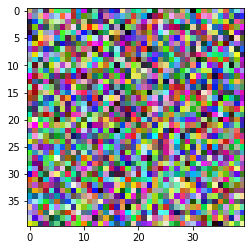

In [14]:
    NUMBER_OF_PIXELS = 1600

    # generating 1600 rgb colors
    pixels = np.random.randint(0, 255, NUMBER_OF_PIXELS * 3) / 100  # scale them into [0, 2.55]
    pixels = pixels.reshape(NUMBER_OF_PIXELS, 3)  # reshape them to rgb shape 1 * 3
    initial_pixels = pixels.reshape((40, 40, 3))
    plt.imshow((initial_pixels * 100).astype(int))
    plt.show()

Iteration 1/20 Average distance = 0.7131139497011322
Iteration 2/20 Average distance = 0.7127042010901006
Iteration 3/20 Average distance = 0.6940605180003697
Iteration 4/20 Average distance = 0.6576417288061148
Iteration 5/20 Average distance = 0.6028011575152101
Iteration 6/20 Average distance = 0.5632774803121517
Iteration 7/20 Average distance = 0.5304147509235111
Iteration 8/20 Average distance = 0.498995871295418
Iteration 9/20 Average distance = 0.4673508783994577
Iteration 10/20 Average distance = 0.4402663460327079
Iteration 11/20 Average distance = 0.41381797664392517
Iteration 12/20 Average distance = 0.38666864675615303
Iteration 13/20 Average distance = 0.3651873357550714
Iteration 14/20 Average distance = 0.3444361596015608
Iteration 15/20 Average distance = 0.32482188812839935
Iteration 16/20 Average distance = 0.30539185603734204
Iteration 17/20 Average distance = 0.2925273911721506
Iteration 18/20 Average distance = 0.275144693170683
Iteration 19/20 Average distance = 

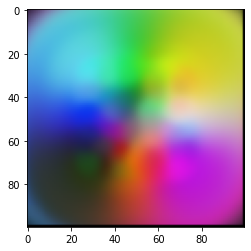

Training has been done !


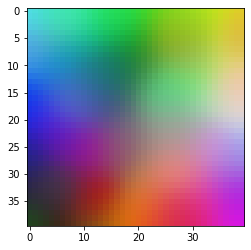

In [15]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.5, n_iter=20, dist_method=Kohonen.EUCLIDEAN)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

Iteration 1/20 Average distance = 0.025058232896490392
Iteration 2/20 Average distance = 0.02282489205256534
Iteration 3/20 Average distance = 0.020985166390298186
Iteration 4/20 Average distance = 0.01886631257482566
Iteration 5/20 Average distance = 0.01683863606913307
Iteration 6/20 Average distance = 0.014694032522448077
Iteration 7/20 Average distance = 0.012636135376093337
Iteration 8/20 Average distance = 0.010804538678600553
Iteration 9/20 Average distance = 0.009176366884335813
Iteration 10/20 Average distance = 0.0077025079372796
Iteration 11/20 Average distance = 0.006453460131598809
Iteration 12/20 Average distance = 0.005419077828993989
Iteration 13/20 Average distance = 0.0044491656753806496
Iteration 14/20 Average distance = 0.0036473318390815583
Iteration 15/20 Average distance = 0.0029859367577280134
Iteration 16/20 Average distance = 0.0024265228829107167
Iteration 17/20 Average distance = 0.001987997972331643
Iteration 18/20 Average distance = 0.0016149513329839183
I

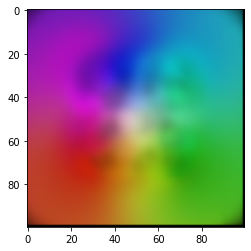

Training has been done !


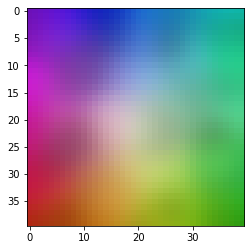

In [16]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.5, n_iter=20, dist_method=Kohonen.COSINE)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

# Q1.B. Kohonen

In [20]:
class Kohonen:
    # distance measurement mechanisms
    COSINE = 'cosine'
    EUCLIDEAN = 'euclidean'
    NONE = 'none'

    LEARNING_RATE_DECAY = 0.78
    UPDATE_RANGE_FACTOR = 0.75
    UPDATE_RANGE_DECAY = 0.75

    def __init__(self, width, height, dimension):
        self.x = width
        self.y = height
        self.node_dim = dimension

        # fitting main variables
        self.n_iter = 0  # number of the iterations
        self.batch_size = 0  # number of each batch
        self.input_arr = np.array([])  # input array, given in fit function
        self.dist_method = Kohonen.NONE  # the distance mechanism

        self.node_vectors = np.array([])  # nodes' vectors

        # learning rate
        self.learning_rate = 0

        self.update_range = 0  # the range and distance that would be updated
        self.neighbor_diff = np.array([])

        self.weights = np.array([])  # the neighbor weights
        self.x_delta = []
        self.y_delta = []

    def init_map(self):
        """
        generates random numbers for node vectors and normalize them with mean of the input array.
        :return:
        """
        random_array = np.random.rand(self.y, self.x, self.node_dim)
        normal_factor = (np.mean(self.input_arr) / np.mean(random_array))
        self.node_vectors = random_array * normal_factor

    def distance(self, vector_a, vector_b):
        """
        calculate the distance between vector_a and vector_b
        :param vector_a:
        :param vector_b:
        :return:
        """
        if self.dist_method == Kohonen.COSINE:
            # https://en.wikipedia.org/wiki/Cosine_similarity
            dist = 1. - np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
        elif self.dist_method == Kohonen.EUCLIDEAN:
            dist = np.linalg.norm(vector_a - vector_b)
        else:
            raise TypeError
        return dist

    def update_node_vectors(self, closest_nodes_idx):
        """
        updating the weights
        :param closest_nodes_idx:
        :return:
        """
        for idx in range(closest_nodes_idx.shape[0]):
            y = closest_nodes_idx[idx, 0]
            x = closest_nodes_idx[idx, 1]
            inp_idx = closest_nodes_idx[idx, 2]
            input_vector = self.input_arr[inp_idx]

            x_range = x + self.x_delta + self.update_range
            y_range = y + self.y_delta + self.update_range

            previous = self.node_vectors[y_range, x_range]

            update_vector = self.weights * self.learning_rate * (np.expand_dims(input_vector, axis=0) - previous)

            self.node_vectors[y_range, x_range, :] += update_vector

    def find_best_matching_node(self, data_vector):
        """
        this method is for finding best & closest vector.
        :param data_vector:
        :return: (x, y, distance) coordinates and distance
        """
        min_dist = None
        x = None
        y = None
        for y_idx in range(self.y):
            for x_idx in range(self.x):
                node_vector = self.node_vectors[y_idx + self.update_range, x_idx + self.update_range]
                dist = self.distance(data_vector, node_vector)
                if min_dist is None or min_dist > dist:
                    min_dist = dist
                    x = x_idx
                    y = y_idx

        return y, x, min_dist

    def calculate_neighbor_diff(self):
        """
        find diff for calculating sigma. diff is (x[i,j] - mean) ^ 2
        :return:
        """
        size = self.update_range * 2
        mean = size / 2.0

        diff = []
        y_delta = []
        x_delta = []
        for i in range(size):
            diff.append([])
            for j in range(size):
                diff[i].append([])
                for k in range(self.node_dim):
                    diff[i][j].append((j - mean) ** 2.0 + (i - mean) ** 2.0)
                y_delta.append(i - int(mean))
                x_delta.append(j - int(mean))

        self.neighbor_diff = np.array(diff)
        self.x_delta = np.array(x_delta, dtype=np.int32)
        self.y_delta = np.array(y_delta, dtype=np.int32)

    def calculate_neighbor_effect(self, iteration):
        """
        calculate the effect of update for the neighbors using Gaussian bell equation.
        :param iteration: the equation depends on the iteration index
        :return:
        """

        size = self.update_range * 2

        # standard deviation
        standard_deviation_factor = (size / 2) * Kohonen.UPDATE_RANGE_DECAY ** (iteration * 0.3 + 1)
        standard_deviation = standard_deviation_factor * (np.sum(self.neighbor_diff) ** (1 / 2)) / size ** 2

        # standard calculate the Gaussian bell plot
        e_factor = 1.0 / (math.sqrt(2 * math.pi) * standard_deviation)
        e_exponent_factor = (-1 / 2) * (1 / standard_deviation) ** 2
        weights = e_factor * math.e ** (e_exponent_factor * self.neighbor_diff)

        weights /= np.max(weights)
        weights = weights.reshape(size * size, 3)
        self.weights = weights

    def fit(self, input_arr, n_iter, batch_size=30, learning_rate=0.25, random_sampling=1.0, dist_method=EUCLIDEAN):
        """
        fit method is for training kohonen map.
        :param input_arr:
        :param n_iter:
        :param batch_size:
        :param learning_rate:
        :param random_sampling:
        :param dist_method:
        :return:
        """

        self.input_arr = input_arr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.dist_method = dist_method
        self.learning_rate = learning_rate
        self.update_range = int(min(self.x, self.y) * Kohonen.UPDATE_RANGE_FACTOR)

        self.init_map()

        # add some fake element to the vectors to ease the process of updating neighbors
        radius = self.update_range
        size = 2 * radius
        tmp_node_vectors = np.zeros((self.y + size, self.x + size, self.node_dim))
        tmp_node_vectors[radius: radius + self.y, radius: radius + self.x] = self.node_vectors.copy()
        self.node_vectors = tmp_node_vectors

        # sampling and batches
        n_samples = int(self.input_arr.shape[0] * random_sampling)
        data_idx_arr = np.arange(self.input_arr.shape[0])
        np.random.shuffle(data_idx_arr)
        batch_count = math.floor(n_samples / self.batch_size)

        self.calculate_neighbor_diff()

        # training
        for iter_idx in range(self.n_iter):

            # calculate update effect on the neighbors
            self.calculate_neighbor_effect(iter_idx)

            # Temporary variables
            total_dist = 0

            for batch in range(batch_count):
                closest_nodes_idx = np.zeros((self.batch_size, 3), dtype=np.int32)

                for item in range(self.batch_size):
                    input_idx = data_idx_arr[batch * self.batch_size + item]
                    input_vector = self.input_arr[input_idx]
                    y, x, dist = self.find_best_matching_node(input_vector)
                    closest_nodes_idx[item, 0] = y
                    closest_nodes_idx[item, 1] = x
                    closest_nodes_idx[item, 2] = input_idx
                    total_dist += dist

                self.update_node_vectors(closest_nodes_idx)

            print('Iteration {}/{} Average distance = {}'.format(iter_idx + 1, self.n_iter, total_dist / n_samples))

            self.learning_rate *= Kohonen.LEARNING_RATE_DECAY

        import matplotlib.pyplot as plt
        plt.imshow((self.node_vectors * 100).astype(int))
        plt.show()

        # Remove padding from the vector map
        self.node_vectors = self.node_vectors[self.update_range: self.update_range + self.y,
                            self.update_range: self.update_range + self.x]

        print("Training has been done !")


Iteration 1/20 Average distance = 0.7041050295775032
Iteration 2/20 Average distance = 0.7082130172843294
Iteration 3/20 Average distance = 0.6592496827150995
Iteration 4/20 Average distance = 0.6225373114183196
Iteration 5/20 Average distance = 0.5864145170615669
Iteration 6/20 Average distance = 0.5514278262173528
Iteration 7/20 Average distance = 0.5199235988323985
Iteration 8/20 Average distance = 0.4907644327199803
Iteration 9/20 Average distance = 0.464413699968129
Iteration 10/20 Average distance = 0.44059210905708307
Iteration 11/20 Average distance = 0.4195957517194062
Iteration 12/20 Average distance = 0.4012050585244464
Iteration 13/20 Average distance = 0.38519356097001783
Iteration 14/20 Average distance = 0.37127437977639105
Iteration 15/20 Average distance = 0.3594990832240192
Iteration 16/20 Average distance = 0.34973190189319375
Iteration 17/20 Average distance = 0.34172759236822325
Iteration 18/20 Average distance = 0.33534155225558526
Iteration 19/20 Average distance

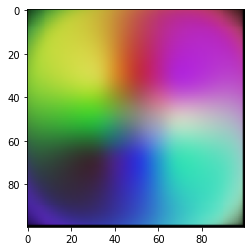

Training has been done !


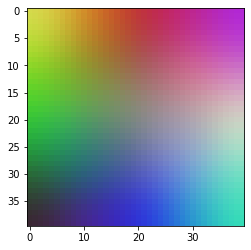

In [21]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.5, n_iter=20, dist_method=Kohonen.EUCLIDEAN)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

Iteration 1/20 Average distance = 0.026426859029136492
Iteration 2/20 Average distance = 0.022329786349325916
Iteration 3/20 Average distance = 0.020245334655924548
Iteration 4/20 Average distance = 0.0181373208870851
Iteration 5/20 Average distance = 0.015993826550449928
Iteration 6/20 Average distance = 0.013901878234601832
Iteration 7/20 Average distance = 0.011991538550489782
Iteration 8/20 Average distance = 0.010296622980386576
Iteration 9/20 Average distance = 0.008816855347129587
Iteration 10/20 Average distance = 0.007561861470766729
Iteration 11/20 Average distance = 0.0065094009133222705
Iteration 12/20 Average distance = 0.005615400531862835
Iteration 13/20 Average distance = 0.004899515736557579
Iteration 14/20 Average distance = 0.004326891182733551
Iteration 15/20 Average distance = 0.0038744839138406552
Iteration 16/20 Average distance = 0.0035219326099375226
Iteration 17/20 Average distance = 0.0032506260068138203
Iteration 18/20 Average distance = 0.003042464332626742

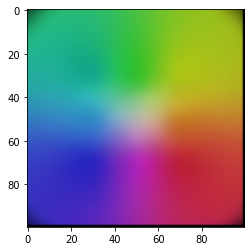

Training has been done !


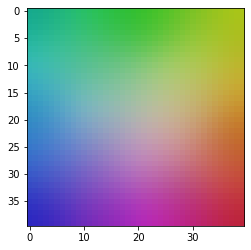

In [22]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.5, n_iter=20, dist_method=Kohonen.COSINE)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

# Q2.A. MLP

In [ ]:
#write your code here

# Q2.B. RBF

In [ ]:
#write your code here

# Q2.C. Compare

In [ ]:
#write your code here

# <font color='red'>Submission</font>

1. Sign up in [Gradescope](https://www.gradescope.com) with proper name and student ID and use the following code to join the class: <font color='red'>**D5372R**</font>
2. Fill in your full name (seperated by single spaces) and student ID in the beginning of this notebook.
3. After you're done with this notebook, you should do the following:
  - Clear all outputs of the notebook.
  ![clear all outputs](https://i.ibb.co/y6FrttB/Screen-Shot-2021-03-21-at-01-51-42.png)
  - Run all of the cells (if you skipped a question just leave the cell unchanged), and make sure all of your outputs are correct.
  ![run all](https://i.ibb.co/cgRcBZ0/Screen-Shot-2021-03-21-at-01-54-58.png)
  - Save your notebook.
  
  - If you're using Colab, download your notebook.
  ![download ipynb](https://i.ibb.co/2KxYM6K/Screen-Shot-2021-03-21-at-02-03-50.png)
  
  - Put the notebook file you just downloaded and `convert.py` in the same folder run the following command:
  ```bash
  python convert.py
  ```
  This will export your code for each question into a `.py` file.
   

  according to the question number.
  - There are 2 assignments in Gradescope: 

    You should upload your **codes** and your **notebook** in `HW2` section and your final report for all of the questions as a **single pdf** file in `HW2 - Report`. Autograder will automatically check for:
    - `CI992_HW2.ipynb`
    - `Q1.A. Kohonen.py`
    - `Q1.B. Koohonen.py`
    - `Q2.A. MLP.py`
    - `Q2.B. RBF.py`
    - `Q2.C. Compare.py`
    - Your name and ID in the beginning of `.ipynb` file.

    It is important that you <font color='red'>**don't**</font> change the names of these files before submission.

4. If you pass the autograder, you're good to go.